# UCL AI Society Machine Learning Tutorials
## Hands-On Project: Real-time Hand Gesture Recognition for Sign Language

### Introduction to The Project
Majority of deaf-and-mute people use sign language produced by body actions such as hand gestures, body motion, eyes and facial expressions to communicate amongst each other and with non-impaired people in their daily life. However, it has become a barrier for mute and deaf communities which intend to integrate into society. Therefore, it is significant to have a medium that can recognize and translate gesture into understandable words by common people, as the information carried by hand gestures is always principal in sign language. To bridge the communication gap, a hand gesture recognition system for Sign Language Recognition (SLR) is required.

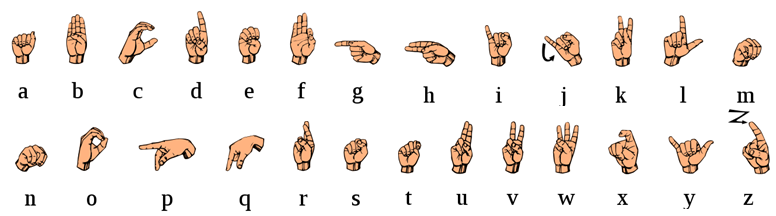

This project aims to design a real-time vision-based hand gesture recognition system with machine learning techniques, which potentially makes deaf-and-mute people life easier. In practice, signs are always continuously spelled words mixing both dynamic and static gestures, so the wanted recognition system should be able to recognize both dynamic and static gestures in ASL with a promising accuracy.

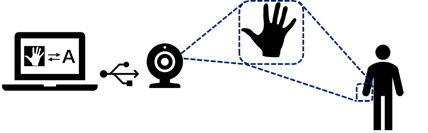

### Aim
At the end of this session, you will be able to:
- Understand basic image processing techniques and their implementation
- Get familiar with advantages and disadvantages of a set of machine learning models
- Have practical experience in conducting an individual project
- Know how to apply the state-of-the-art techniques in your own work.

### Outline
Typically, a real-time SLR systems follow a common framework and process, i.e. data acquisition, pre-processing, feature extraction and classification

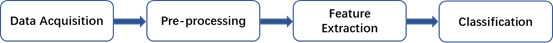

This notebook is formulated as a baseline framework in non-real-time training and testing, and you are encouraged to:

    1) Modify to improve any applied technique in any stage, e.g. preprocessing, feature extraction, classification. 
    2) Propose your own implementations to replace the original technique, which might lead to an amazing improvement.
    3) Assemble elements into a real-time recognition system and play with it.
    
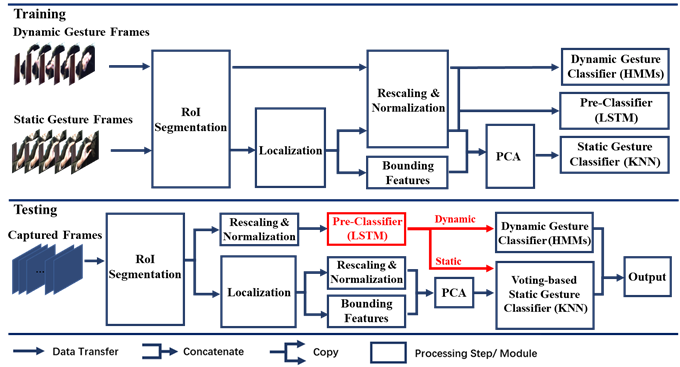

### Dataset

The train dataset for training and validation purpose is divided into staitc and dynamic gestures, where images of each letter is stored in an independent file folder. There are 400 samples for each static gesture (A, B, C, D, E, F, G, H, L, U) from 5 signers, 40 samples (each sample contains 10 of continuous frames) for each dynamic gesture (J and Z) from 2 signers. All gestures are from the ASL alphabet. Examples are shown below:

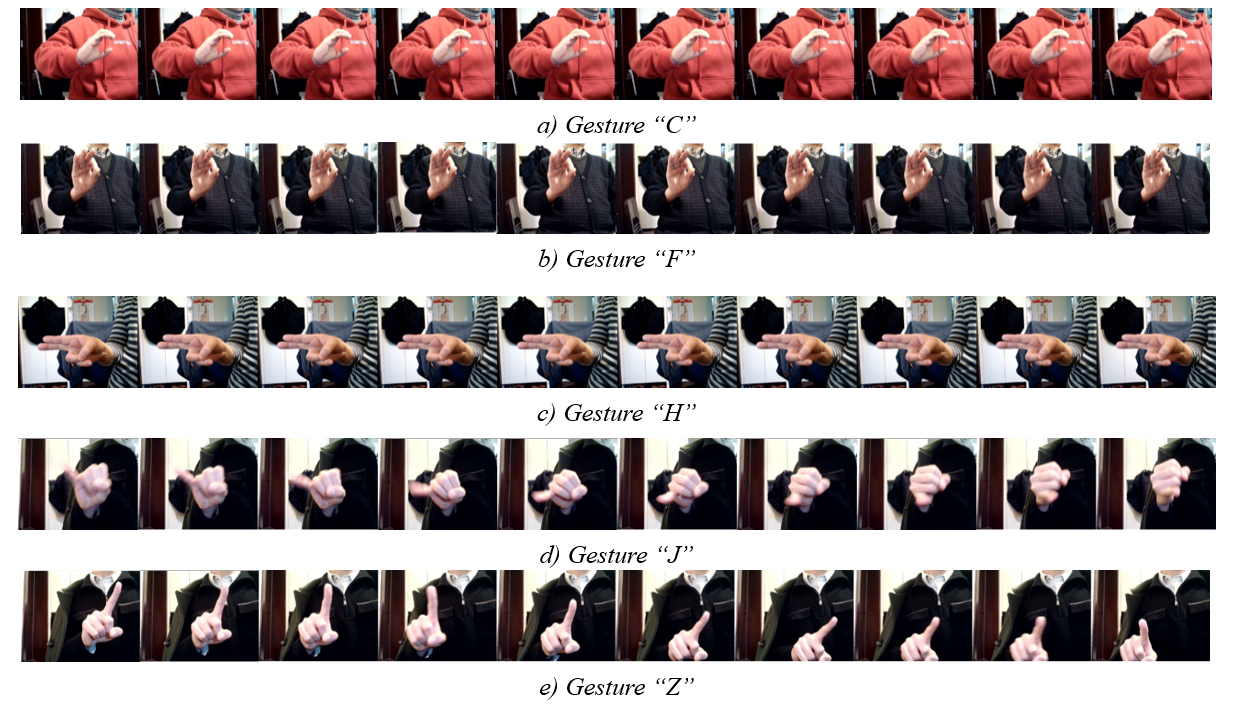

The test dataset has similar structure with 100 samples for each static gesture and 40 samples for each dynamic gesture.

### Step 1 & 2: Data Loading and Preprocessing (Training and Validation Set)

Now, let's start from reading and datasets. Note that it's not a good way to load all the original data and cache them together in the memory, so a skin-color segmentation and a Region of Interest (RoI) cropping technique is applied into the read image. In this way, the size of cached data is much smaller. The two applied techniques are packaged in `preprocessing.py` files. It would be a great practice if you could design your own preprocessing algorithms.

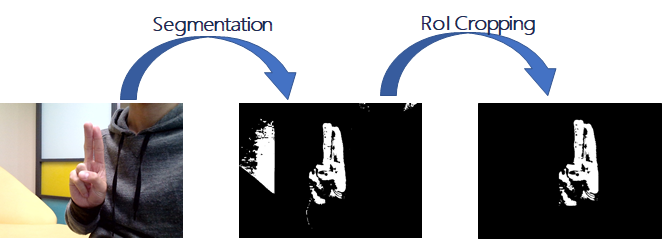

The basic idea of skin-color segmentation is filter out the region within a preset color range in a certain color space, where the 3-channel images are transformed into binary image highlighting hand regions. In this case, we operate this segmentation in HSV color space with a set of thresholds to limit the wanted range. You may want to tune these thresholds in function `Segmentation()`.

For RoI cropping, a fast and effective cropping algorithm is applied based on two criteria: 

    a) Sparse Distribution of Noise on the Edge;
    b) Centrality Distribution of Hand. 

Criterion a) assumes that sparse effective points introduced by similar color noise in the background distribute dispersedly near the edge area with limited number, and Criterion b) assumes the hand prefers appearing around the center of the image rather than near the edge. Formal expression of the algorithm is not presented for simplicity.

First, let's import some useful moudules.

In [1]:
import numpy as np
import preprocessing as pp
import cv2
import time
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.models import Sequential
from hmmlearn import hmm
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


`ProcessBar()` is defined to monitor the progress of preprocessing.

In [2]:
def ProcessBar(count,letNum,sample_per_letter):
    bar='\r %.2f%% %s%s (%d processed, duration: %.2fs)'
    sampleNum=letNum*sample_per_letter
    if (count+1)%1==0:
        duration=time.time()-start
        F='#'*int((count+1)/(sampleNum*0.025))
        nF='-'*int((sampleNum-(count+1))/(sampleNum*0.025))
        percentage=((count+1)/(sampleNum))*100
        print(bar %(percentage, F, nF, count+1,duration),end='')

`processing_demo()` is defined to demonstrate examples of processed image in each preprocessing stage.

In [3]:
def processing_demo(img, segmentation, cropping1, cropping3, reinsertImg, rescale):
    b,g,r = cv2.split(img)  
    img_show = cv2.merge([r,g,b])
    
    display.clear_output(wait=True)
    
    fig = plt.figure(figsize=(10,4))
    axes1 = fig.add_subplot(231)
    axes1.imshow(img_show)
    axes1.set_xticks([])
    axes1.set_yticks([])
    axes1.set_title("Original Image")

    axes2 = fig.add_subplot(232)
    axes2.imshow(segmentation, cmap= 'gray')
    axes2.set_xticks([])
    axes2.set_yticks([])
    axes2.set_title("Segmented Image")

    axes3 = fig.add_subplot(233)
    axes3.imshow(cropping1, cmap= 'gray')
    axes3.set_xticks([])
    axes3.set_yticks([])
    axes3.set_title("Cropped Image (1st iteration)")

    axes4 = fig.add_subplot(234)
    axes4.imshow(cropping3, cmap= 'gray')
    axes4.set_xticks([])
    axes4.set_yticks([])
    axes4.set_title("Cropped Image (3rd iteration)")

    axes5 = fig.add_subplot(235)
    axes5.imshow(reinsertImg, cmap= 'gray')
    axes5.set_xticks([])
    axes5.set_yticks([])
    axes5.set_title("Re-inserted Image")
    
    axes6 = fig.add_subplot(236)
    axes6.imshow(rescale, cmap= 'gray')
    axes6.set_xticks([])
    axes6.set_yticks([])
    axes6.set_title("Rescaled Image")
    
    plt.pause(0.01)
    display.display(plt.gcf())

Firstly, let's configure name of classes.

In [4]:
static=['A','B','C','D','E','F','G','H','L','U']
dynamic = ['J','Z']

flatten_images = []
gesture = []
DyOrSt = []
aspect_ratio=[]

# If want to demo. processing examples, set it as True
demo_example = False

Firstly load and process the static gestures. For static gestures, we further consider aspect ratio as the bounding feature.

In [5]:
count=0
letterNum_static = len(static)
sampleNum_static = 400
print("Loading and Processing Training Dataset (Static)...")
start=time.time()

## load static gestures
for letter in static:
    for sample in range(sampleNum_static):    
        ProcessBar(count,letterNum_static,sampleNum_static)
        img=cv2.imread("./dataset/train/static/"+letter+"/"+letter+"%d.jpg" % (sample))
        seg=pp.Segmentation(img)
        # E1, E2 and E3 is to record how much rows and columns are cropped in each cropping step
        cropping1,E1=pp.Cropping(seg)
        cropping2,E2=pp.Cropping(cropping1)
        cropping3,E3=pp.Cropping(cropping2)
        # E describe how much rows and cols are cropped in total
        E=np.array(E1)+np.array(E2)+np.array(E3)
        # Initialize a empty binary image with same size as the original image
        retImg=np.zeros((600,800))
        #insert the cropped image to keep the location information of the gesture
        retImg[E[0]:600-E[1],E[2]:800-E[3]]=cropping3
        # Rescale the image in 32*32 to save memory
        scale = cv2.resize(retImg, (32, 32), cv2.INTER_LINEAR)
        # Flatten the image into vector and append it to the processed dataset
        flatten_images.append(scale.flatten()/255.)
        # Record aspect ratio as the bounding feature
        aspect_ratio.append(cropping3.shape[0]/cropping3.shape[1])
        # class label
        gesture.append(static.index(letter))  
        # dynamic or static label
        DyOrSt.append(0)
        # Demo.
        if (sample+1)%100 == 0 and demo_example:
            processing_demo(img, seg, cropping1, cropping3, retImg, scale)
        count+=1

Loading and Processing Training Dataset (Static)...
 100.00% ######################################## (4000 processed, duration: 327.44s)

Then, load and process dynamic gestures. Mind the different naming approach in dynamic gesture images, e.g. J1_0.jpg means the first frame of the second sample

In [6]:
count=0
letterNum_dynamic = len(dynamic)
sampleNum_dynamic = 40
frame_per_sample = 10
print("Loading and Processing Training Dataset (Dynamic)...")
start=time.time()

for letter in dynamic:
    for sample in range(sampleNum_dynamic): 
        for frame in range(frame_per_sample):
            ProcessBar(count,letterNum_dynamic,sampleNum_dynamic*frame_per_sample)
            img=cv2.imread("./dataset/train/dynamic/"+letter+"/"+letter+"%d_%d.jpg" % (sample,frame))
            seg=pp.Segmentation(img)
            # E1, E2 and E3 is to record how much rows and columns are cropped in each cropping step
            cropping1,E1=pp.Cropping(seg)
            cropping2,E2=pp.Cropping(cropping1)
            cropping3,E3=pp.Cropping(cropping2)
            # E describe how much rows and cols are cropped in total
            E=np.array(E1)+np.array(E2)+np.array(E3)
            # Initialize a empty binary image with same size as the original image
            retImg=np.zeros((600,800))
            #insert the cropped image to keep the location information of the gesture
            retImg[E[0]:600-E[1],E[2]:800-E[3]]=cropping3
            # Rescale the image in 32*32 to save memory
            scale = cv2.resize(retImg, (32, 32), cv2.INTER_LINEAR)
            # Flatten the image into vector and append it to the processed dataset
            flatten_images.append(scale.flatten()/255.)
            # class label
            gesture.append(dynamic.index(letter)+10)  
            # dynamic or static label
            DyOrSt.append(1)
            # demo.
            if (sample+1)%10 == 0 and frame==9 and demo_example:
                processing_demo(img, seg, cropping1, cropping3, retImg, scale)
            count+=1

Loading and Processing Training Dataset (Dynamic)...
 100.00% ######################################## (800 processed, duration: 61.16s)

### Step 3: Reform Datasets for Pre-classifier, Static and Dynamic Gesutre Classifiers

The baseline applies a LSTM model as pre-classifier, a KNN model as static gesture classifier and a HMM model as dynamic gesture classifier. The pre-classifier should be applied to distinguish dynamic gestures from static gestures in prior. The classification result of the pre-classifier determines which classifier will be used for gesture recognition. Noticeably, the main difference between frame set of dynamic and static gesture is change of the state associated with the hand gesture, that is, time series analysis techniques are likely to have promising performance in the pre-classification.

Each observation of the datasets used for pre-classification and dynamic gesture classification should be a set of continuous frames, so we reshape the dataset(`flatten_images`) into frame sets instead of individual images. As for static gesutre classification, we not only consider the pixel-wise information but also the bound features represented by the aspect ratio of the RoI (hand region), and thus a concatenated dataset is formed.

In [7]:
# Transform from list to array
flatten_images = np.array(flatten_images)
bounding_feature = np.array(aspect_ratio).reshape(-1,1)
DyOrSt = np.array(DyOrSt)
gesture = np.array(gesture)

Check the loaded dataset.

In [8]:
total_samples = flatten_images.shape[0]
static_samples = np.sum(DyOrSt==0)
dynamic_samples = np.sum(DyOrSt==1)
print("{} images loaded including static: {}, dynamic:{}".format(total_samples ,static_samples,dynamic_samples))

4800 images loaded including static: 4000, dynamic:800


In [9]:
dataset_preclass = flatten_images.reshape(-1,10*flatten_images.shape[1])
label_pre = DyOrSt[::10]
dataset_static = np.hstack((flatten_images[:static_samples],bounding_feature))
label_static = gesture[:static_samples]
dataset_dynamic = dataset_preclass[int(static_samples/10):]
label_dynamic = gesture[-dynamic_samples:][::10]

### Step 4: Train the Classifiers

#### Pre-classifiier: LSTM

LSTM, different from traditional ANNs whose output is directly determined by the instant input, provides a solution that can also comprehensively consider the previous inputs in long-short term.

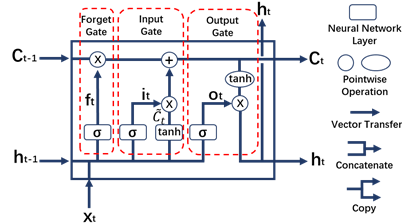

Fig. 6 illustrates a LSTM block with one cell, which is composed of input gate, forget gate and output gate. Firstly, the forget gate determines the proportion of the previous information should be forgot by $ f_t∙C_{t-1} $ , where $ C_{t-1} $ is the previous information in the last LSTM block and $ f_t $ is the proportion. $ f_t $ is determined by the neural network layer with the non-linear $sigmoid$ activation function $σ$, given by:



, where $ W_f $ denotes the connection weight, $ h_{t-1} $ denotes the hidden state at time $t-1$ and $b_f$ denotes the bias. Secondly, the input gate determines which new information should be updated and saved in the cell by $ {i_t} \cdot {\tilde C_t} $, where $tanh$ function generates the value of input $ \tilde C_t $ and it activated by $sigmoid$ function determines the proportion that the new information is involved. They can be expressed by:




, where $W_c$ denotes the connection weight, bc denotes the bias in the neural network layer. Subsequently, the cell state information is updated to $C_t$, given by:

 

Finally, the output gate in the LSTM block determines the output value, depending on the cell state $C_t$. Similarly, a neural network layer with $sigmoid$ activation is used to determine the percentage of cell state after $tanh$ activation that should be output, denoted as $o_t$. Hence, the output percentage $o_t$ and output hidden state $h_t$ are given by:




, where WO denotes the connection weight, bO denotes the bias. In fact, although the three gates in the LSTM block have significant difference in function, the operations they apply are the same, that is, the #sigmoid# function is used as the selection tool, while $tanh$ function is used as the transform tool.

In [10]:
#parameters for LSTM
nb_lstm = 32  #Number of neuron
nb_time_steps = 10  #length of time series
nb_input_vector = 1024 #length of input in each time step
epoch = 10
batch_size = 8

In [11]:
# Split the training and validation set.
trainX_pre, valX_pre, trainY_pre, valY_pre= train_test_split(dataset_preclass, 
                                                             label_pre,
                                                             test_size = 0.2,
                                                             stratify=label_pre)
# Reshape them to adapt LSTM inputs
trainX_pre=trainX_pre.reshape((-1,10,1024))
valX_pre=valX_pre.reshape((-1,10,1024))
# One-hot encoding
trainY_pre = to_categorical(trainY_pre, num_classes=2)
valY_pre = to_categorical(valY_pre, num_classes=2)

# Build LSTM
model = Sequential()
model.add(LSTM(units=nb_lstm, input_shape=(nb_time_steps, nb_input_vector)))
model.add(Dense(2, activation='sigmoid'))

# Train the LSTM
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(trainX_pre, trainY_pre, 
                  epochs=epoch, batch_size=batch_size, verbose=1,
                  validation_data = (valX_pre,valY_pre))
## TODO: Can you rewrite this training process into KFold cross validation?






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 384 samples, validate on 96 samples
Epoch 1/10
384/384 [==============================] - 2s 5ms/step - loss: 0.3496 - acc: 0.8828 - val_loss: 0.2514 - val_acc: 0.9062
Epoch 2/10
384/384 [==============================] - 1s 2ms/step - loss: 0.1909 - acc: 0.9219 - val_loss: 0.1573 - val_acc: 0.9271
Epoch 3/10
384/384 [==============================] - 1s 1ms/step - loss: 0.1033 - acc: 0.9453 - val_loss: 0.0855 - val_acc: 0.9583
Epoch 4/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0386 - acc: 0.9974 - val_loss: 0.0799 - val_acc: 0.9688
Epoch 5/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0263 - acc: 0.9948 - val_loss: 0.0147 - val_acc: 1.0000
Epoch 6/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 1.0000
Epoch 7/10
384/384 [==============================] - 1s 2ms/st

In [12]:
# Evaluate the performance on validation set
pred_preclass = np.argmax(model.predict(valX_pre),axis=1)
valY_pre=np.argmax(valY_pre,axis=1)
PreAcc = accuracy_score(valY_pre, pred_preclass)
PrePrec = precision_score(valY_pre, pred_preclass)
Pref1score = f1_score(valY_pre, pred_preclass)
PreRecall = recall_score(valY_pre, pred_preclass)

print("Pre-Classifer Validation Acc: %.4f" %(PreAcc))
print("Pre-Classifer Validation Precision: %.4f" %(PrePrec))
print("Pre-Classifer Validation f1-score: %.4f" %(Pref1score))
print("Pre-Classifer Validation recall: %.4f" %(PreRecall))

Pre-Classifer Validation Acc: 0.9896
Pre-Classifer Validation Precision: 1.0000
Pre-Classifer Validation f1-score: 0.9677
Pre-Classifer Validation recall: 0.9375


#### Static Gesture Classifier: KNN

Using the features extracted by PCA, KNN can efficiently classify static gestures based on distance measure with relatively smaller computing complexity and better overfitting avoidance.

The principle of KNN in classification is that if majority of the k samples in the feature space belong to a certain class, the given sample also belongs to this class. There are 3 key factors in KNN, i.e. the measure of distance, value of k and decision rule of classification.

Furthermore, the decision rule of classification is normally on voting basis, that is, the majority class of the $k$ nearest samples determines the class of the given sample. Given a sample $x$ which needs classification and the set of the $k$ nearest samples as $N_k(x)$, the determined class of $x$ is denoted as $y$ can be obtained by:

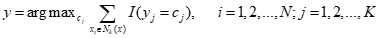

, where $yj∈Y=\{c_1, c_2, …, c_m\}$ and $Y$ is the set of potential classes, $I$ is an indication function given by:

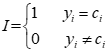


In [13]:
# parameter for KNN
k=5

# Split the training and validation set.
trainX_static, valX_static, trainY_static, valY_static = train_test_split(dataset_static, 
                                                                          label_static,
                                                                          test_size = 0.15)
# Normalization
norm = MinMaxScaler()
trainX_static = norm.fit_transform(trainX_static)
valX_static = norm.transform(valX_static)

# Dimensionality Reduction: PCA
pcaModel = PCA(n_components=50)
trainX_static = pcaModel.fit_transform(trainX_static)
valX_static = pcaModel.transform(valX_static)

# train KNN
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(trainX_static,trainY_static)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
# Evaluate the performance on validation set
pred_static = knn.predict(valX_static)
staticAcc = accuracy_score(valY_static, pred_static)
staticPrec = precision_score(valY_static,pred_static,average='macro')
staticf1score = f1_score(valY_static,pred_static,average='macro')
staticRecall = recall_score(valY_static,pred_static,average='macro')

print("Static Gesture Classifer Validation Acc: %.4f" %(staticAcc))
print("Static Gesture Classifer Validation Precision: %.4f" %(staticPrec))
print("Static Gesture Classifer Validation f1-score: %.4f" %(staticf1score))
print("Static Gesture Classifer Validation recall: %.4f" %(staticRecall))

Static Gesture Classifer Validation Acc: 0.9983
Static Gesture Classifer Validation Precision: 0.9981
Static Gesture Classifer Validation f1-score: 0.9983
Static Gesture Classifer Validation recall: 0.9985


#### Dynamic Gesture Classifier: HMM

Typically, HMM can solve 3 fundamental problems, i.e. evaluation, estimation and decoding, while two important assumptions are given: 

    1. Homogeneous Markova chain assumption: The hidden state at time point t+1 only depends on the hidden state at time point t.
    2. observation independence assumption: The observation state at time t only depends on the hidden state at time t.

Two HMMs, trained by frame sets of dynamic gesture ‘J’ and ‘Z’, are respectively utilized to adapt to each of them. In the training phase of dynamic gesture classification, the HMM solves the estimation problem, that is, given continuous frame set as the observation series $O=\{o1, o2,…, oT\}$, the model parameter $λ’=(A’, B’, ∏’)$ should be estimated, which can maximize the conditional probability of observation series appearing in the model $P(O|λ)$. To solve estimation problem of HMM, Baum-Welch algorithm is typically used. In the testing phase of pre-classification, the HMM solves the evaluation problem, that is, given model parameter $λ=(A, B, ∏)$, and observation series $O=\{o1, o2,…, oT\}$, the conditional probability of observation series appearing in the model $P(O|λ)$ is computed. The evaluation problem can be efficiently solved by using forward-backward algorithm with a relatively lower computing complexity. In testing phase, the predicted class $y’$ should be the class of the model which outputs maximum probability, which can be expressed by:


    

In [15]:
# parameter for HMM
n_states_J=1
n_states_Z=1

# Split the training and validation set.
trainX_dynamic, valX_dynamic, trainY_dynamic, valY_dynamic = train_test_split(dataset_dynamic, 
                                                                              label_dynamic,
                                                                              test_size = 0.2,
                                                                              stratify=label_dynamic)
# Transform label into binary
valY_dynamic -=10

# Split training set to ensure HHM_J is trained with gesture J, HMM_Z is trained with gesture Z
trainSet_dyn=np.hstack((trainX_dynamic,trainY_dynamic.reshape(-1,1)))
yy=trainSet_dyn[:,10240]-10
x_trainSplit= np.array ( [trainSet_dyn[yy==i,:10240] for i in range(2)] )
y_trainSplit= np.array ( [trainSet_dyn[yy==i,10240] for i in range(2)] )

# train HMMs
HMM_J = hmm.GaussianHMM(n_components=n_states_J)
HMM_Z = hmm.GaussianHMM(n_components=n_states_Z)   
HMM_J.fit(x_trainSplit[0])
HMM_Z.fit(x_trainSplit[1])

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=1, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [16]:
# Evaluate the performance on validation set
score=[]
for i in range(len(valY_dynamic)):
    score.append([(HMM_J.score(valX_dynamic[i,:].reshape(1,-1))),
                  (HMM_Z.score(valX_dynamic[i,:].reshape(1,-1)))])

pred_dynamic=np.argmax(score,axis=1)
dynamicAcc = accuracy_score(valY_dynamic, pred_dynamic)
dynamicPrec = precision_score(valY_dynamic, pred_dynamic)
dynamicf1score = f1_score(valY_dynamic, pred_dynamic)
dynamicRecall = recall_score(valY_dynamic, pred_dynamic)

print("Dynamic Gesture Classifer Validation Acc: %.4f" %(dynamicAcc))
print("Dynamic Gesture Classifer Validation Precision: %.4f" %(dynamicPrec))
print("Dynamic Gesture Classifer Validation f1-score: %.4f" %(dynamicf1score))
print("Dynamic Gesture Classifer Validation recall: %.4f" %(dynamicRecall))

Dynamic Gesture Classifer Validation Acc: 1.0000
Dynamic Gesture Classifer Validation Precision: 1.0000
Dynamic Gesture Classifer Validation f1-score: 1.0000
Dynamic Gesture Classifer Validation recall: 1.0000


### Step 5: Assemble Elements and Test the Recognition System

Now we want to assemble the trained models into a completed system shown below for testing:

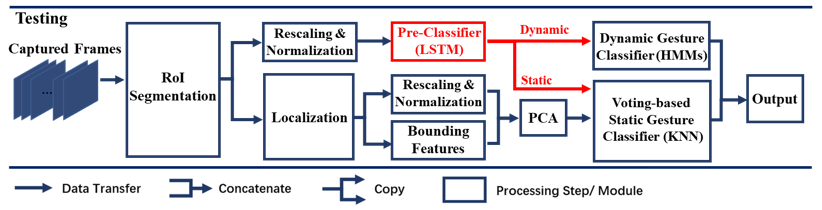

In the test phase, classification is made in sample-wise rather than frame-wise. Therefore, there are 10 observations (images) to recognize not only dynamic gesutre but also static gesture, that is, after every frame of the set is independently classified by the KNN, the classification results are combined to obtain the final classification result of the frame set. An intuitive combining approach is voting, which means the predicted class with the most votes is the final classification result ($y’$) of the frame set, given by:

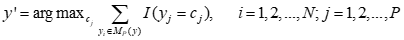

, $M_p(y)$ is the set of all independent classification results, $P$ is the number of the frames in a frame set.


In [17]:
# Clean memory to cache test data
flatten_images = []
gesture = []
DyOrSt = []
aspect_ratio=[]

In [18]:
## TODO: Load and process the test data of static gestures
# Hint: Mind the sample index of fifth signer (start from <letter>_320.jpg)

count=0
letterNum_static = len(static)
sampleNum_static = 100
print("Loading and Processing Test Dataset (Static)...")
start=time.time()

## load static gestures
for letter in static:
    for sample in range(sampleNum_static):    
        None

Loading and Processing Test Dataset (Static)...
 100.00% ######################################## (1000 processed, duration: 81.29s)

In [19]:
## TODO: Load and process the test data of dynamic gestures
# Hint: Mind the sample index of second signer (start from <letter>20_0.jpg)

count=0
letterNum_dynamic = len(dynamic)
sampleNum_dynamic = 40
frame_per_sample = 10
print("\n")
print("Loading and Processing Test Dataset (Dynamic)...")
start=time.time()

for letter in dynamic:
    for sample in range(sampleNum_dynamic): 
        for frame in range(frame_per_sample):
            None



Loading and Processing Test Dataset (Dynamic)...
 100.00% ######################################## (800 processed, duration: 65.80s)

In [20]:
# Transform from list to numpy array
flatten_images = np.array(flatten_images)
bounding_feature = np.array(aspect_ratio).reshape(-1,1)
bounding_feature = np.vstack((bounding_feature,np.zeros((800,1))))
DyOrSt = np.array(DyOrSt)
gesture = np.array(gesture)[::10]
# Check how many images are loaded
total_samples = int(flatten_images.shape[0]/10)
static_samples = int(np.sum(DyOrSt==0)/10)
dynamic_samples = int(np.sum(DyOrSt==1)/10)
print("{} images loaded including static: {}, dynamic:{}".format(total_samples ,static_samples,dynamic_samples))

180 images loaded including static: 100, dynamic:80


Now, let's classify the samples in the test set.

In [21]:
# classify the samples in the test set
frame_set = flatten_images.reshape(-1,10*flatten_images.shape[1])
pred_test = []

for sample in range(total_samples):  
    frames = frame_set[sample].reshape((-1,10,1024))
    ## TODO: classify the input sample to dynamic or static using LSTM model
    preclass = None
    if preclass == 0:
        data_static = frame_set[sample].reshape(-1,1024)
        data_static = np.hstack((data_static,bounding_feature[10*sample:10*(sample+1)]))
        data_static = norm.transform(data_static)
        data_static = pcaModel.transform(data_static)
        # 10 frames are classified using KNN independently
        # voteVector records the classifying results
        voteVector=list(knn.predict(data_static))
        ## TODO: determine which static gesture the input sample is by take the majority class in the voteVector
        pred=None
        pred_test.append(pred)
    elif preclass == 1:
        ## TODO: classify which dynamic gesture the input sample is.
        score_J= None
        score_Z= None
        pred= None
        pred_test.append(pred)

In [22]:
# System performance
testAcc = accuracy_score(gesture, pred_test)
testPrec = precision_score(gesture, pred_test,average='macro')
testf1score = f1_score(gesture, pred_test,average='macro')
testRecall = recall_score(gesture, pred_test,average='macro')

print("Overall Test Acc: %.4f" %(testAcc))
print("Overall Test Precision: %.4f" %(testPrec))
print("Overall Test f1-score: %.4f" %(testf1score))
print("Overall Test recall: %.4f" %(testRecall))

Overall Test Acc: 0.8056
Overall Test Precision: 0.8236
Overall Test f1-score: 0.7871
Overall Test recall: 0.7833


Think about why the test performance is much lower than that of every separate classifier?

In [23]:
## TODO: Improve the baseline framework by your own implementation